In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
!pip install causal-learn

In [80]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.image as mpimg
import io

from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [143]:
#loading osprey data
osprey_path = '/content/drive/MyDrive/ml_climate_project_data/osprey/'

csv_files = [f for f in os.listdir(osprey_path) if f.endswith('.csv')]

osprey_df = pd.concat(
    [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
    ignore_index = True
)

#getting rid of missing / non-numeric values
osprey_df['OBSERVATION COUNT'] = pd.to_numeric(osprey_df['OBSERVATION COUNT'], errors = 'coerce')
osprey_df = osprey_df.dropna(subset = ['OBSERVATION COUNT'])

osprey_df = osprey_df[['OBSERVATION DATE', 'OBSERVATION COUNT', 'COUNTY']]

<ipython-input-143-293e71d5ad60>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-143-293e71d5ad60>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-143-293e71d5ad60>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-143-293e71d5ad60>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-143-293e71d5ad60>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memo

In [144]:
#loading bald_eagle data
eagle_path = '/content/drive/MyDrive/ml_climate_project_data/bald_eagle/'

csv_files = [f for f in os.listdir(eagle_path) if f.endswith('.csv')]
bald_eagle_df = pd.concat(
    [pd.read_csv(os.path.join(eagle_path, file)) for file in sorted(csv_files)],
    ignore_index = True
)

#getting rid of missing / non-numeric values
bald_eagle_df['OBSERVATION COUNT'] = pd.to_numeric(bald_eagle_df['OBSERVATION COUNT'], errors = 'coerce')
bald_eagle_df = bald_eagle_df.dropna(subset = ['OBSERVATION COUNT'])

bald_eagle_df = bald_eagle_df[['OBSERVATION DATE', 'OBSERVATION COUNT', 'COUNTY']]

In [83]:
#fish data
fish_df = pd.read_csv('/content/drive/MyDrive/ml_climate_project_data/fishdata.csv')

#temperature data
temp_df = pd.read_csv('/content/drive/MyDrive/ml_climate_project_data/tempdata.csv')

temp_df = temp_df[temp_df['Anomaly'] != -999]

temp_df['year'] = temp_df['Date'].astype(str).str[:4].astype(int)
temp_df['month'] = temp_df['Date'].astype(str).str[4:].astype(int)

In [142]:
#combine and join data
osprey_df["bird_type"] = "Osprey"
bald_eagle_df["bird_type"] = "Bald Eagle"
bird_df = pd.concat([osprey_df, bald_eagle_df], ignore_index = True)

bird_df['OBSERVATION DATE'] = pd.to_datetime(bird_df['OBSERVATION DATE'])
bird_df['year'] = bird_df['OBSERVATION DATE'].dt.year
bird_df['month'] = bird_df['OBSERVATION DATE'].dt.month

#combine with temperature data
bird_temp_df = bird_df.merge(temp_df[['year', 'month', 'Anomaly']], on=['year', 'month'], how='left')

#combine with fish data
combined_df = bird_temp_df.merge(fish_df, on='year', how='left')
final_df = combined_df.dropna()
final_df = final_df.rename(columns={
    "Anomaly": "temperature",
    "OBSERVATION COUNT": "bird_count",
    "Fish_Population": "fish_population",
})

In [145]:
#data setup
final_df['interaction_temp_osprey'] = final_df['temperature'] * (final_df['bird_type'] == 'Osprey').astype(int)
final_df['interaction_temp_bald_eagle'] = final_df['temperature'] * (final_df['bird_type'] == 'Bald Eagle').astype(int)
final_df['interaction_fish_osprey'] = final_df['runsize'] * (final_df['bird_type'] == 'Osprey').astype(int)
final_df['interaction_fish_bald_eagle'] = final_df['runsize'] * (final_df['bird_type'] == 'Bald Eagle').astype(int)

features = ['temperature', 'runsize', 'interaction_temp_osprey', 'interaction_temp_bald_eagle',
            'interaction_fish_osprey', 'interaction_fish_bald_eagle']
target = 'bird_count'
X = final_df[features].values
y = final_df[target].values
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [146]:
#merge data
final_df['OBSERVATION DATE'] = pd.to_datetime(final_df['OBSERVATION DATE'])

monthly_summary = final_df.groupby(['year', 'month', 'bird_type']).agg({
    'bird_count': 'sum',
    'temperature': 'mean',
    'runsize': 'mean',
    'spawners': 'mean'
}).reset_index()

bird_pivot = monthly_summary.pivot_table(index = ['year', 'month'],
                                         columns = 'bird_type',
                                         values = 'bird_count',
                                         fill_value = 0).reset_index()

bird_pivot.columns.name = None
bird_pivot = bird_pivot.rename(columns = {
    'Osprey': 'osprey_count',
    'Bald Eagle': 'bald_eagle_count'
})

temp_fish = monthly_summary.groupby(['year', 'month']).agg({
    'temperature': 'mean',
    'runsize': 'mean',
    'spawners': 'mean'
}).reset_index()

merged_df = pd.merge(bird_pivot, temp_fish, on = ['year', 'month'], how = 'left')
merged_df['interaction'] = merged_df['temperature'] * merged_df['bald_eagle_count']

In [89]:
#dag
causal_data = merged_df.drop(columns = ['year', 'month'])
X = causal_data.values
Record = ges(X)

pyd = GraphUtils.to_pydot(Record['G'])
tmp_png = pyd.create_png(f = "png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format = 'png')

node_labels = [node.get_name() for node in Record['G'].nodes]

column_names = causal_data.columns.tolist()
node_to_column_map = dict(zip([f'X{i+1}' for i in range(len(column_names))], column_names))

target_column = 'bald_eagle_count'

target_node_label = next(label for label, col in node_to_column_map.items() if col == target_column)
node_labels = [node.get_name() for node in Record['G'].nodes]

target_column = 'bald_eagle_count'
target_node = None
for node in Record['G'].nodes:
    if node.get_name() == target_node_label:
        target_node = node
        break

if target_node is None:
    print(f"Error: Node '{target_node_label}' not found in the graph.")
else:
    parents_of_target = Record['G'].get_parents(target_node)
    parent_columns = [node_to_column_map[parent.get_name()] for parent in parents_of_target]

nodes = Record['G'].get_nodes()
name_to_node = {node.get_name(): node for node in nodes}

target_node_label = 'X2'
target_node = name_to_node[target_node_label]

parents_of_X2 = Record['G'].get_parents(target_node)

In [ ]:
#linear regression

In [ ]:
#

In [140]:
#random forest
#modeling fish availability based on temperature and spawners
merged_df['fish_availability'] = merged_df['temperature'] * merged_df['spawners']

X_fish = merged_df[['temperature', 'spawners']]
y_fish = merged_df['fish_availability']

#random forest for fish availability
model_fish = RandomForestRegressor()
model_fish.fit(X_fish, y_fish)

merged_df['predicted_fish_availability'] = model_fish.predict(X_fish)
print("R² for Fish Availability Model:", r2_score(y_fish, merged_df['predicted_fish_availability']))

X_bald_eagle = merged_df[['temperature', 'spawners', 'predicted_fish_availability']]
y_bald_eagle = merged_df['bald_eagle_count']

#random forest for bald eagle
model_bald_eagle = RandomForestRegressor()
model_bald_eagle.fit(X_bald_eagle, y_bald_eagle)

merged_df['predicted_bald_eagle_count'] = model_bald_eagle.predict(X_bald_eagle)
print("R² for Bald Eagle Population Model:", r2_score(y_bald_eagle, merged_df['predicted_bald_eagle_count']))

X_osprey = merged_df[['temperature', 'spawners', 'predicted_fish_availability']]
y_osprey = merged_df['osprey_count']

#random forest for osprey
model_osprey = RandomForestRegressor()
model_osprey.fit(X_osprey, y_osprey)

merged_df['predicted_osprey_count'] = model_osprey.predict(X_osprey)
print("R² for Osprey Population Model:", r2_score(y_osprey, merged_df['predicted_osprey_count']))

merged_df['predicted_interaction_term'] = merged_df['predicted_bald_eagle_count'] * merged_df['predicted_osprey_count']
X_interaction = merged_df[['predicted_bald_eagle_count', 'predicted_osprey_count']]
model_interaction_term = RandomForestRegressor()
model_interaction_term.fit(X_interaction, merged_df['interaction'])
merged_df['predicted_interaction_term'] = model_interaction_term.predict(X_interaction)

R² for Fish Availability Model: 0.9987079508073972
R² for Bald Eagle Population Model: 0.8942797562286711
R² for Osprey Population Model: 0.9597344408417511


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


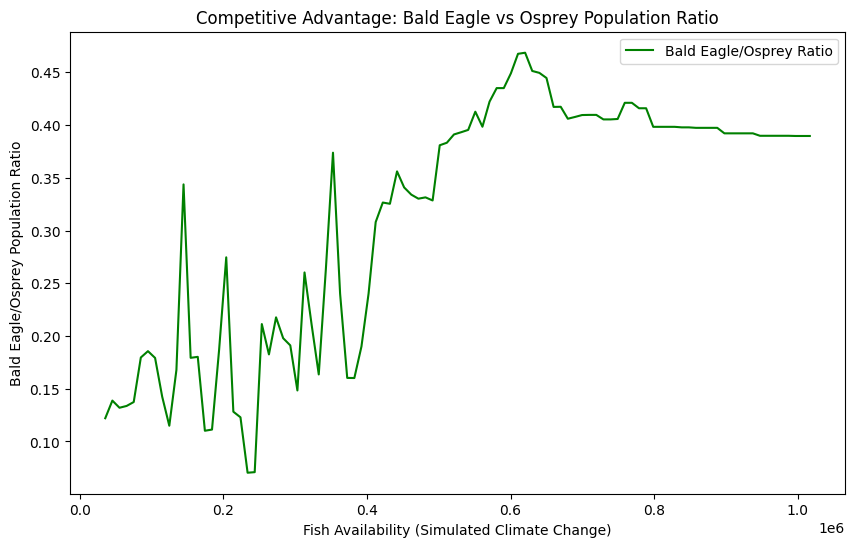

In [141]:
#simulating ratio based on fish availability
fish_availability_base = merged_df['fish_availability'].mean()

temperature_range = np.linspace(merged_df['temperature'].min(), merged_df['temperature'].max(), 100)
spawners_range = np.linspace(merged_df['spawners'].min(), merged_df['spawners'].max(), 100)
fish_availability_range = fish_availability_base + 0.01 * (temperature_range - merged_df['temperature'].mean()) \
                          + 0.5 * (spawners_range - merged_df['spawners'].mean())

fish_availability_range = np.maximum(fish_availability_range, 0)
simulated_bald_eagle_population = model_bald_eagle.predict(np.column_stack([np.ones_like(fish_availability_range)*merged_df['temperature'].mean(),
                                                                           np.ones_like(fish_availability_range)*merged_df['spawners'].mean(),
                                                                           fish_availability_range]))

simulated_osprey_population = model_osprey.predict(np.column_stack([np.ones_like(fish_availability_range)*merged_df['temperature'].mean(),
                                                                   np.ones_like(fish_availability_range)*merged_df['spawners'].mean(),
                                                                   fish_availability_range]))

population_ratio = simulated_bald_eagle_population / simulated_osprey_population

plt.figure(figsize = (10, 6))
plt.plot(fish_availability_range, population_ratio, label='Bald Eagle/Osprey Ratio', color = 'g')
plt.xlabel('Fish Availability (Simulated Climate Change)')
plt.ylabel('Bald Eagle/Osprey Population Ratio')
plt.title('Competitive Advantage: Bald Eagle vs Osprey Population Ratio')
plt.legend()
plt.show()